In [ ]:
#| default_exp run

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export 

import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
from torchmetrics import AUROC
from sklearn.metrics import roc_auc_score

from typing import Any, Union, Tuple

In [ ]:
#| export
_size_2_t = Union[int, Tuple[int, int]]

In [ ]:
from captum_trial.model import ConvNet, ConvBnRelu
from captum_trial.data import get_dls
from collections import OrderedDict

![Overview of Attribution Algorithms](../images/Captum_Attribution_Algos.png)

The primary audiences for Captum are model developers who are looking to improve their models and understand which features are important and interpretability researchers focused on identifying algorithms that can better interpret many types of models.

Captum can also be used by application engineers who are using trained models in production. Captum provides easier troubleshooting through improved model interpretability, and the potential for delivering better explanations to end users on why they’re seeing a specific piece of content, such as a movie recommendation.

In [ ]:
dls = get_dls(batch_size=20) # has train and valid dataloaders

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_classes = 10

# Visualize the filters

In [ ]:
m = ConvNet(n_cls=num_classes)

/mnt/data/captum_trial/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
saved_model = torch.load('../nbs/lightning_logs/version_37/checkpoints/epoch=4-step=12500.ckpt') 

In [ ]:
# keys are slighly different in saved model

weights_ordered_dict = OrderedDict()
saved_wts = saved_model['state_dict']
for i, k in enumerate(m.state_dict().keys()) :
    print(i, k)
    weights_ordered_dict.update({k:saved_wts[f'model.{k}']})
    

0 conv1.conv.weight
1 conv1.conv.bias
2 conv1.bn.weight
3 conv1.bn.bias
4 conv1.bn.running_mean
5 conv1.bn.running_var
6 conv1.bn.num_batches_tracked
7 conv2.conv.weight
8 conv2.conv.bias
9 conv2.bn.weight
10 conv2.bn.bias
11 conv2.bn.running_mean
12 conv2.bn.running_var
13 conv2.bn.num_batches_tracked
14 linear.weight
15 linear.bias


In [ ]:
try:
    trained_model = trainer.model.model
except NameError:
    # if not trained, load from cache
    trained_model = ConvNet(n_cls=num_classes)
    trained_model.load_state_dict(state_dict=weights_ordered_dict)

In [ ]:
list(trained_model.children())

[ConvBnRelu(
   (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
   (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Dropout2d(p=0.2, inplace=False),
 ConvBnRelu(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
   (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Dropout2d(p=0.2, inplace=False),
 Flatten(start_dim=1, end_dim=-1),
 LazyLinear(in_features=0, out_features=10, bias=True)]

In [ ]:
conv_layers = [x.conv for x in trained_model.children() if isinstance(x, ConvBnRelu) if hasattr(x, 'conv')]
conv_layers

[Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))]

In [ ]:
model_parameters = [] 
for lyr in conv_layers:
    print(lyr.weight.shape)
    model_parameters.append(lyr.weight)

torch.Size([16, 3, 3, 3])
torch.Size([32, 16, 3, 3])


In [ ]:
import matplotlib.pyplot as plt

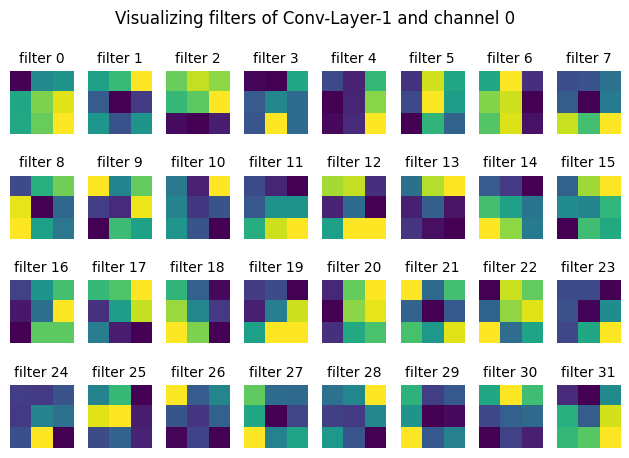

In [ ]:
conv_layer_idx = 1
channel=0
for i, filter in enumerate(model_parameters[conv_layer_idx]):
        f_c = filter[channel].detach().numpy() # 3x3
        plt.subplot(4, 4*(conv_layer_idx+1), i+1)
        plt.imshow(f_c)
        plt.title(f"filter {i}", fontdict={'size':10, 'font':'sans'})
        plt.axis('off')
plt.suptitle(f'Visualizing filters of Conv-Layer-{conv_layer_idx} and channel {channel}')
plt.tight_layout() 
 

In [ ]:
# get sample data
_, dls_test = dls
for imgs, targets in dls_test:
    break

imgs.shape
idx = 19
sample_img = imgs[idx].unsqueeze(0)
img = imgs[idx].unsqueeze(0)
target = int(targets[idx].item())
img.shape, target

(torch.Size([1, 3, 32, 32]), 6)

In [ ]:
img_array = img.squeeze().permute(1, 2, 0).numpy().astype('uint')

In [ ]:
img_array.shape, img_array.dtype

((32, 32, 3), dtype('uint64'))

Text(0.5, 1.0, 'class: 6')

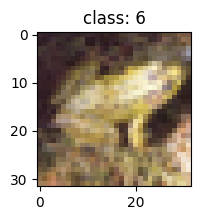

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(img_array)
plt.title(f"class: {target}")

In [ ]:
sample_img.shape

torch.Size([1, 3, 32, 32])

In [ ]:
conv_layer_result = []
for conv_op in conv_layers:
    if len(conv_layer_result) < 1:
        conv_layer_result.append(conv_op(sample_img))
    else:
        conv_layer_result.append(conv_op(conv_layer_result[-1]))


In [ ]:
[x.shape for x in conv_layer_result]

[torch.Size([1, 16, 30, 30]), torch.Size([1, 32, 28, 28])]

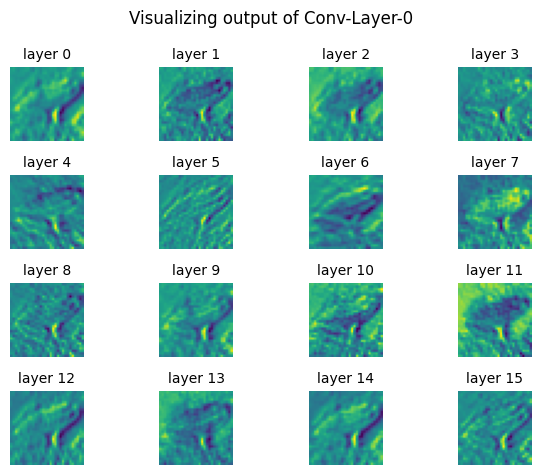

In [ ]:
conv_layer_idx = 0
for i, outs in enumerate(conv_layer_result[conv_layer_idx].squeeze()):
        outs_c = outs.detach().numpy() # 30x30
        plt.subplot(4, 4*(conv_layer_idx+1), i+1)
        plt.imshow(outs_c)
        plt.title(f"layer {i}", fontdict={'size':10, 'font':'sans'})
        plt.axis('off')
plt.suptitle(f'Visualizing output of Conv-Layer-{conv_layer_idx}')
plt.tight_layout() 

# Using Captum to visualize Saliency map

In [ ]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, visualization
import numpy as np

In [ ]:
sample_img.shape

torch.Size([1, 3, 32, 32])

In [ ]:
captum_input = torch.clone(sample_img) # should clone to avoid accumulating to same tree
captum_input.requires_grad = True

In [ ]:
img_array.shape, captum_input.shape

((32, 32, 3), torch.Size([1, 3, 32, 32]))

In [ ]:
img_array.dtype

dtype('uint64')

For the following block of code to work
> Edit the visualization.py file:
> 
> Open the visualization.py file located in captum/attr/_utils/ folder.
> 
> Look for the line plt_axis.grid(b=False).
> 
> Change it to plt_axis.grid(visible=False).
> 
> Save the file.

In [ ]:
cat ../.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py | grep plt_axis.grid

    plt_axis.grid(visible=False)


In [ ]:
# to replace inplace

! sed -i "s/b=False/visible=False/" ../.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py 

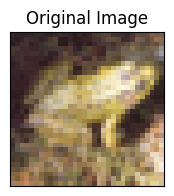

(<Figure size 200x200 with 1 Axes>, <Axes: title={'center': 'Original Image'}>)

In [ ]:
visualization.visualize_image_attr(
    None,
    original_image=img_array,
    method="original_image",
    title="Original Image",
    fig_size=(2, 2),
)

In [ ]:
# saliency paper: https://arxiv.org/abs/1312.6034
saliency = Saliency(trained_model)
gradients = saliency.attribute(captum_input, target=target)

In [ ]:
captum_input.shape, gradients.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 32, 32]))

In [ ]:
gradients = gradients.squeeze().permute(1, 2, 0).numpy()
gradients.shape

(32, 32, 3)

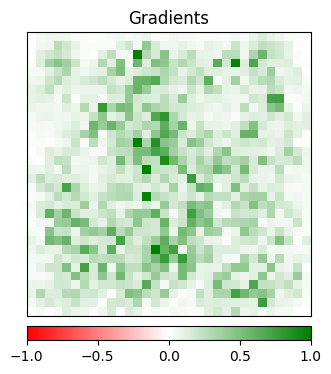

(<Figure size 400x400 with 2 Axes>, <Axes: title={'center': 'Gradients'}>)

In [ ]:
visualization.visualize_image_attr(
    gradients,
    original_image=None,
    method="heat_map",
    alpha_overlay=0.5,
    sign="all",
    show_colorbar=True,
    fig_size=(4, 4),
    title="Gradients",
)

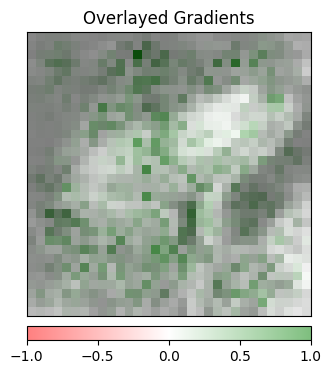

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'Overlayed Gradients'}>)

In [ ]:
visualization.visualize_image_attr(
    gradients,
    original_image=img_array,
    method="blended_heat_map",
    alpha_overlay=0.5,
    sign="all",
    show_colorbar=True,
    fig_size=(4, 4),
    title="Overlayed Gradients",
)

# Using Captum to visualize Integrated gradients

In [ ]:
captum_input = torch.clone(sample_img) # should clone to avoid accumulating to same tree
baselines = torch.zeros_like(captum_input)
captum_input.requires_grad = True

In [ ]:
# integrated gradients paper: https://arxiv.org/abs/1703.01365
# accumulates gradients to a baseline image (zeros); this should mean feature importance
intgrad = IntegratedGradients(trained_model)
gradients, delta = intgrad.attribute(captum_input, target=target, baselines=baselines, return_convergence_delta=True)

In [ ]:
delta

tensor([1.3003], dtype=torch.float64)

In [ ]:
gradients = gradients.squeeze().permute(1, 2, 0).detach().numpy()
gradients.shape

(32, 32, 3)

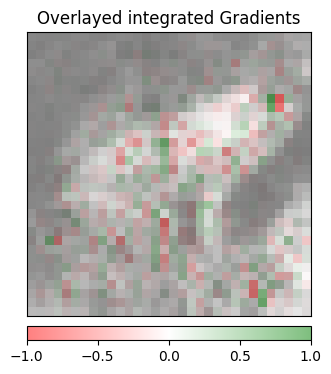

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'Overlayed integrated Gradients'}>)

In [ ]:
visualization.visualize_image_attr(
    gradients,
    original_image=img_array,
    method="blended_heat_map",
    alpha_overlay=0.5,
    sign="all",
    show_colorbar=True,
    fig_size=(4, 4),
    title="Overlayed integrated Gradients",
)

# Using Captum to visualize DeepLift

In [ ]:
captum_input = torch.clone(sample_img) # should clone to avoid accumulating to same tree
baselines = torch.zeros_like(captum_input)
captum_input.requires_grad = True

In [ ]:
# again gradient based attribution technique
deeplift = DeepLift(trained_model)
gradients, delta = deeplift.attribute(captum_input, target=target, baselines=baselines, return_convergence_delta=True)

In [ ]:
delta

tensor([0.9277])

In [ ]:
gradients = gradients.squeeze().permute(1, 2, 0).detach().numpy()
gradients.shape

(32, 32, 3)

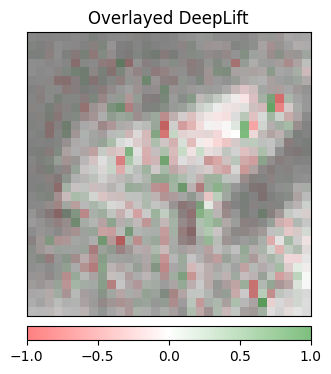

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'Overlayed DeepLift'}>)

In [ ]:
visualization.visualize_image_attr(
    gradients,
    original_image=img_array,
    method="blended_heat_map",
    alpha_overlay=0.5,
    sign="all",
    show_colorbar=True,
    fig_size=(4, 4),
    title="Overlayed DeepLift",
)

# Using Captum to visualize GradCAM

In [ ]:
from captum.attr import GuidedGradCam

# Ensure that all ReLU operations in the forward function of the given model are 
# performed using a module (nn.module.ReLU). If nn.functional.ReLU is used, 
# gradients are not overridden appropriately.

In [ ]:
captum_input = torch.clone(sample_img) # should clone to avoid accumulating to same tree
captum_input.requires_grad = True

In [ ]:
# Guided gradCAM paper: https://arxiv.org/abs/1610.02391
gradcam = GuidedGradCam(trained_model, layer=trained_model.conv2)
gradients = gradcam.attribute(captum_input, target=target)

In [ ]:
gradients.shape

torch.Size([1, 3, 32, 32])

In [ ]:
gradients = gradients.squeeze().permute(1, 2, 0).detach().numpy()
gradients.shape

(32, 32, 3)

In [ ]:
gradients.clip(max=1e-8).shape # should I clip?

(32, 32, 3)

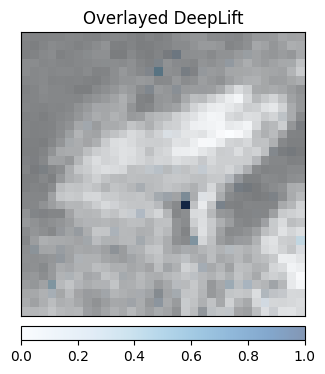

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'Overlayed DeepLift'}>)

In [ ]:
visualization.visualize_image_attr(
    gradients,
    original_image=img_array,
    method="blended_heat_map",
    alpha_overlay=0.5,
    sign="absolute_value",
    show_colorbar=True,
    fig_size=(4, 4),
    title="Overlayed DeepLift",
)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()